In [9]:
import torch 
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torch.optim import Adam, AdamW, RMSprop, Adagrad 
# import lpips


import os
import cv2
from skimage.color import rgb2lab
import numpy as np
from PIL import Image 
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [109]:
device

'cuda'

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [99]:
print(len(train_data), len(test_data))

7129 5000


In [19]:
class CustomDataset(Dataset):
    def __init__(self, grays, colors, gray_transform=None, color_transform=None):
        self.grays_dir = grays
        self.colors_dir = colors
        self.gray_transform = gray_transform
        self.color_transform = color_transform

        self.gray_images = sorted(os.listdir(self.grays_dir))
        self.color_images = sorted(os.listdir(self.colors_dir))

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_img_path = os.path.join(self.grays_dir, self.gray_images[idx])
        color_img_path = os.path.join(self.colors_dir, self.color_images[idx])

        
        gray_img = Image.open(gray_img_path).convert("L")
        color_img = Image.open(color_img_path).convert("RGB")

        
        if self.color_transform:
            color_img = self.color_transform(color_img)

        if self.gray_transform:
            gray_img = self.gray_transform(gray_img)


        return gray_img, color_img



In [20]:
color_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

gray_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [21]:
colored = "/kaggle/input/landscape-image-colorization/landscape Images/color"
grays = "/kaggle/input/landscape-image-colorization/landscape Images/gray"

In [22]:
data = CustomDataset(grays, colored, gray_transform = gray_transform, color_transform = color_transforms)

In [23]:
len(data)

7129

In [96]:
# len(train_data)

7129

In [97]:
# len(test_data)

5000

In [24]:
train_data, test_data = random_split(data, [0.9, 0.1])

In [25]:
len(train_data)

6417

In [26]:
len(test_data)

712

In [27]:
def output(limit, dataset):
    count = 0
    
    fig, axes = plt.subplots(limit, 2, figsize=(10, 5 * limit))
    
    for x, y in dataset:
        x = x.permute(1, 2, 0)
        y = y.permute(1, 2, 0)
    
        axes[count, 0].imshow(x)
        axes[count, 0].set_title("Gray image")
        axes[count, 0].axis("off")
    
        axes[count, 1].imshow(y)
        axes[count, 1].set_title("Colorized image")
        axes[count, 1].axis("off")
        
        count += 1
        if count >= limit: 
            break
    
    
    plt.tight_layout()
    plt.show()

In [28]:
output(5, train_data)

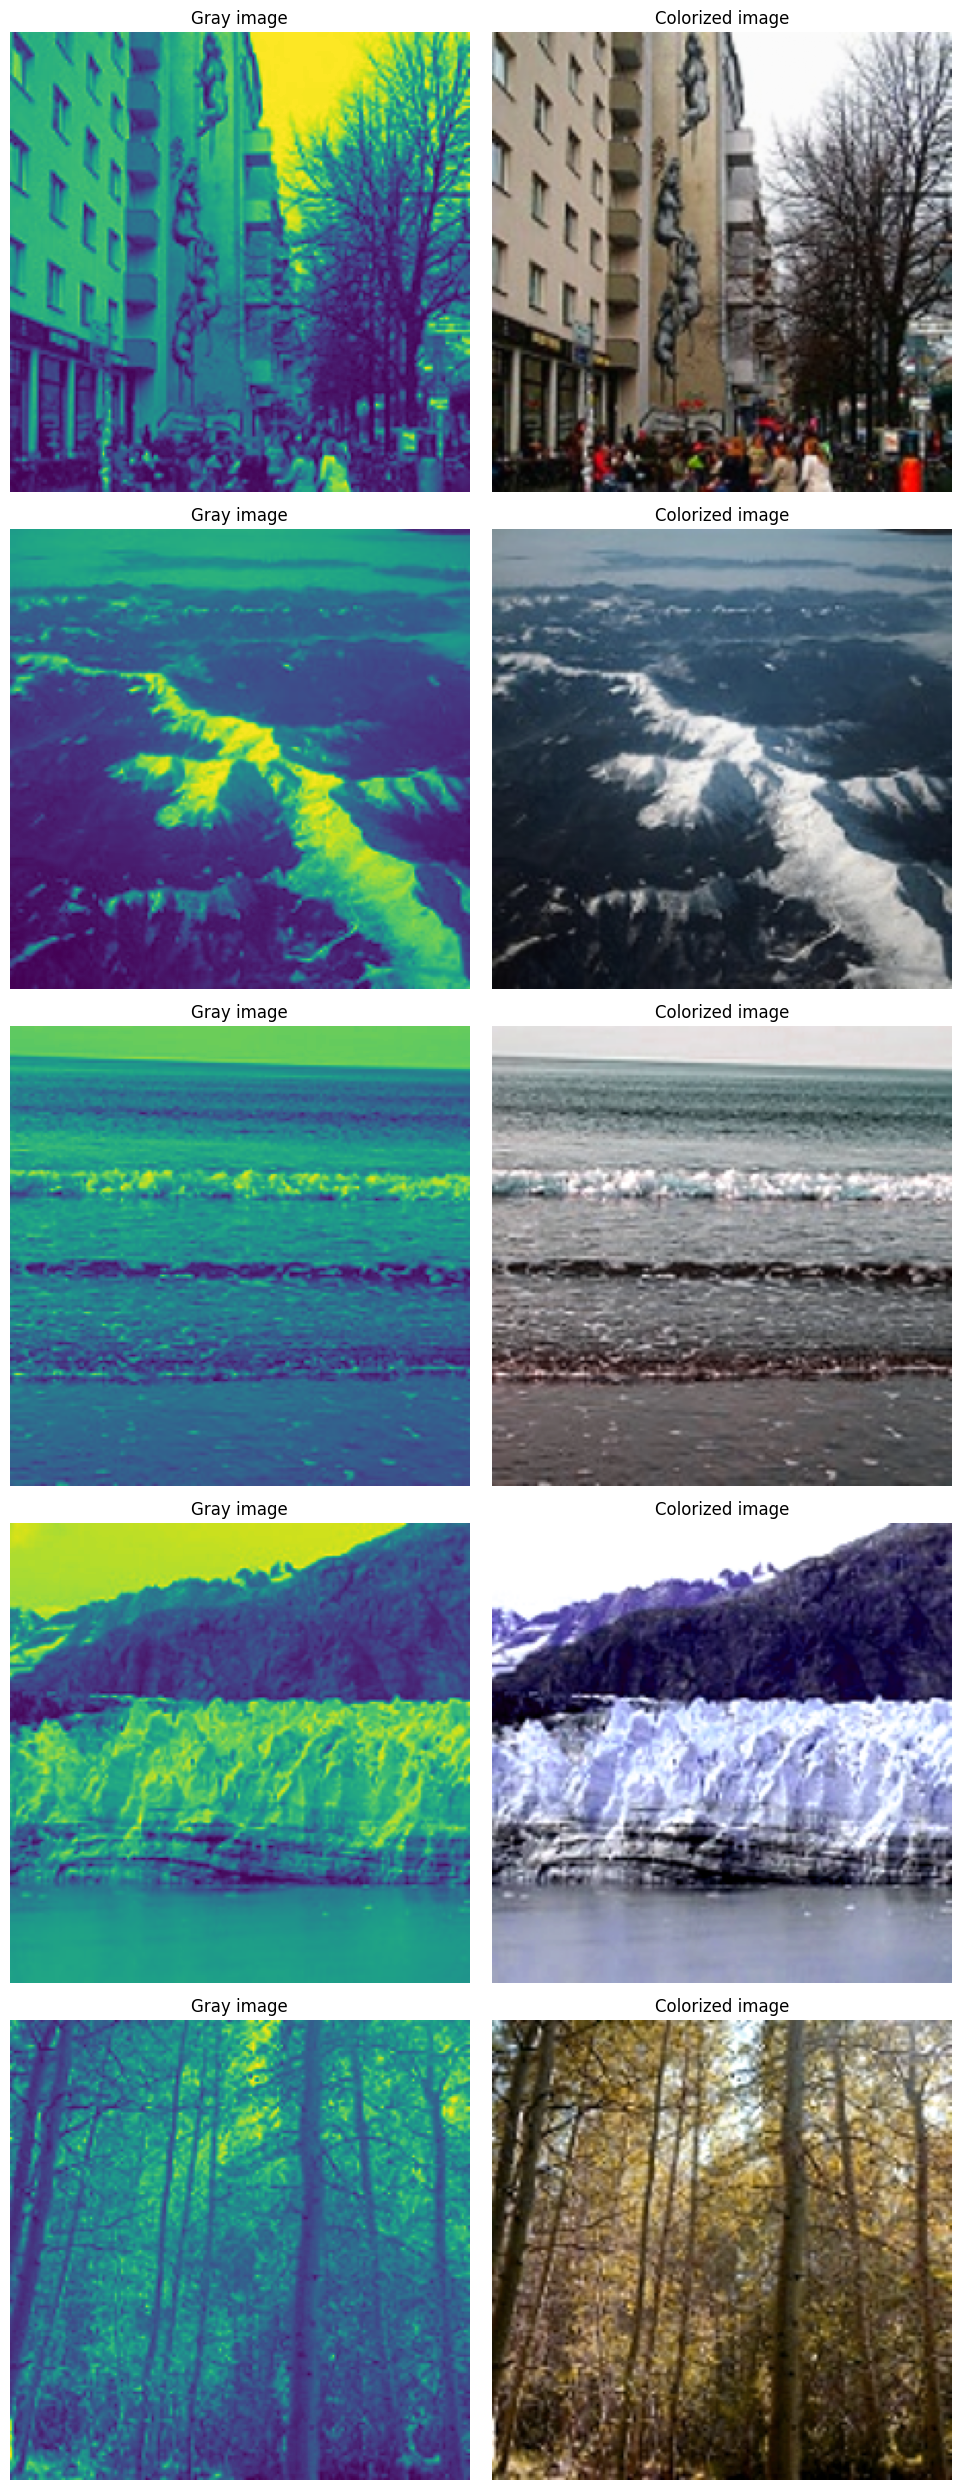

In [30]:
output(5, test_data)

In [33]:
batch_size = 64
train_dl = DataLoader(train_data, batch_size = batch_size, generator=torch.Generator(device="cpu"))
val_dl = DataLoader(test_data, batch_size = batch_size, generator=torch.Generator(device="cpu"))

In [34]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool = False, upsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.add_conv = nn.Sequential()

        if in_channels != out_channels:
            self.add_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None


        if upsample == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        else:
            self.upsample = None
            

    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_conv(x)

        
        out = F.relu(out)
        out = self.conv2(out)
        out += add_out

        out = F.relu(out)

        if self.pool:
            out = self.pool(out)

        if self.upsample:
            out = self.upsample(out)

        return out  

In [47]:
class SkipTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()

        self.transpose1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 3, padding = 1)
        self.transpose2 = nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size = 3, padding = 1)

        self.add_transpose = nn.Sequential()

        if in_channels != out_channels:
            self.add_transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 3, padding = 1)

        if upsample == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        else:
            self.upsample = None

    def forward(self, x):
        out = self.transpose1(x)
        add_out =  self.add_transpose(x)

        out = F.relu(out)

        out = self.transpose2(out)
        out += add_out

        if self.upsample:
            out = self.upsample(out)

        out = F.relu(out)

        return out
        

In [52]:
block = SkipTransposeBlock(32, 16, upsample=True)
tensor = torch.rand(1, 32, 224, 224)

out = block(tensor)
out.shape

torch.Size([1, 16, 448, 448])

In [53]:
block = SkipBlock(3, 32, pool = True)
tensor = torch.rand(3, 224, 224)

out = block(tensor)
out.shape

torch.Size([32, 112, 112])

In [54]:
block = SkipBlock(32, 3, upsample = True)
tensor = torch.rand(1, 32, 112, 112)

out = block(tensor)
out.shape

torch.Size([1, 3, 224, 224])

In [55]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, rate):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, rate, kernel_size = 3, padding = 1)
        self.bnorm = nn.BatchNorm2d(rate)

    def forward(self, x):
        out = self.conv(x)
        out = self.bnorm(out)
        out = F.relu(out)
        res = torch.concat([x, out], dim=1)
        
        return res 

In [56]:
block = DenseLayer(16, 16)
tesnor = torch.rand(1, 16, 224, 224)

out = block(tesnor)
out.shape

torch.Size([1, 32, 224, 224])

In [57]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, rate, num_layers, pool = False, upsample = False):
        super().__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()

        for i in range(num_layers):
            self.layers.append(DenseLayer(in_channels, rate))
            in_channels += rate

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None


        if upsample == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        else:
             self.upsample = None

        

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        if self.pool:
            x = self.pool(x)

        if self.upsample:
            x = self.upsample(x)

        return x

In [58]:
block = DenseBlock(32, 6, 4, pool = True)
tensor = torch.rand(1, 32, 224, 224)

out = block(tensor)
out.shape

torch.Size([1, 56, 112, 112])

In [59]:
block = DenseBlock(32, 6, 4, upsample = True)
tensor = torch.rand(1, 32, 224, 224)

out = block(tensor)
out.shape

torch.Size([1, 56, 448, 448])

In [86]:
class SEBlock(nn.Module):
    def __init__(self, C, r):
        super().__init__()

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(C, C//r)
        self.linear2 = nn.Linear(C//r, C)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.aap(x)
        out = self.flatten(out)

        out = self.linear1(out)
        out = self.relu(out)

        out = self.linear2(out)
        out = self.sigmoid(out)

        out = out[:, :, None, None]
        res = out * x

        return res

In [62]:
block = SEBlock(32, 2)
tensor = torch.rand(1, 32, 224, 224)

out = block(tensor)
out.shape

torch.Size([1, 32, 224, 224])

In [92]:
class Painter(nn.Module):
    def __init__(self):
        super().__init__()

        # self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, padding=1)
        # 1, 224, 224
        self.skip_block1 = SkipBlock(1, 32, pool = True)
        self.se_block1_1 = SEBlock(32, 16)
        # 32, 112, 112
        self.skip_block2 = SkipBlock(32, 64, pool = True)
        # 64, 64, 64
        self.skip_block3 = SkipBlock(64, 128, pool = True)
        self.se_block1_3 = SEBlock(128, 16)
        # 128, 32, 32
        self.up_conv1 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size=7, padding=3)
        # 128, 32, 32
        self.up_conv_block2 = SkipTransposeBlock(256, 64, upsample = True)
        # 64, 64, 64
        self.up_conv_block3 = SkipTransposeBlock(128, 32, upsample = True)
        # 32, 112, 112
        self.up_conv_block4 = SkipTransposeBlock(64, 3, upsample = True)
        # 3, 224, 224
        



    def forward(self, x):
        # 1, 224, 224
        out1 = self.skip_block1(x)
        out1 = self.se_block1_1(out1)
        # 32, 112, 112
        out2 = self.skip_block2(out1)
        # 64, 64, 64
        out3 = self.skip_block3(out2)
        out3 = self.se_block1_3(out3)
        # 128, 32, 32
        
        up4 = self.up_conv1(out3)
        up4 = F.leaky_relu(up4)
        # 128, 32, 32

        up4 = torch.concat([out3, up4], dim=1)
        # 256, 32, 32
        up3 = self.up_conv_block2(up4)
        # 64, 64, 64

        up3 = torch.concat([out2, up3], dim=1)
        # 128, 64, 64
        up2 = self.up_conv_block3(up3)
        # 32, 112, 112

        up2 = torch.concat([out1, up2], dim=1)
        # 64, 112, 112
        res = self.up_conv_block4(up2)
        # 3, 224, 224

        return res 

    def predict(self, x):
        self.eval()
        x = x.to(device)

        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        with torch.no_grad():
            out = self.forward(x)

        return out 

    
        


        

        


        

In [93]:
model = Painter()
tensor = torch.rand(1, 224, 224).to(device)
model.to(device)

out = model.predict(tensor)
out.shape

torch.Size([1, 3, 224, 224])

In [20]:
tensor = torch.rand(3, 224, 224)
tensor = tensor.unsqueeze(0)
len(tensor.shape)

4

In [35]:
!pip install torchsummary

In [94]:
from torchsummary import summary

model = Painter()
model.to(device)

summary(model, input_size = (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
            Conv2d-2         [-1, 32, 224, 224]             320
            Conv2d-3         [-1, 32, 224, 224]           9,248
         MaxPool2d-4         [-1, 32, 112, 112]               0
         SkipBlock-5         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                    [-1, 2]              66
              ReLU-9                    [-1, 2]               0
           Linear-10                   [-1, 32]              96
          Sigmoid-11                   [-1, 32]               0
          SEBlock-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          18,496
           Conv2d-14         [-1, 64, 1

In [125]:
def train(model, train_dl, val_dl, loss_fn, psnr, ssim, optimizer, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_psnr": [],
        "val_psnr": [],
        "train_ssim": [],
        "val_ssim": []
    }

    for epoch in range(epochs):
        
        model.train()
        train_loss = 0.0
        train_psnr = 0.0
        train_ssim = 0.0
        
        for gray, colored in tqdm(train_dl):
            gray = gray.to(device)
            colored = colored.to(device)

            optimizer.zero_grad()

            preds = model(gray)


            loss = loss_fn(preds, colored)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()


            t_psnr = psnr(preds.cpu().detach().numpy(), colored.cpu().detach().numpy(), data_range=1.0)
            train_psnr += t_psnr
            t_ssim = ssim(preds.cpu().detach().numpy(), colored.cpu().detach().numpy(), win_size=3, channel_axis=-1, data_range=1.0)
            train_ssim += t_ssim

        total_train_loss = train_loss / len(train_dl)
        total_train_psnr = train_psnr / len(train_dl)
        total_train_ssim = train_ssim / len(train_dl)

        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        val_ssim = 0.0
        
        with torch.no_grad():
            for gray, colored in tqdm(val_dl):
                gray = gray.to(device)
                colored = colored.to(device)

                preds = model(gray)

   
                loss = loss_fn(preds, colored)
                val_loss += loss.item()

  
                psnr_value = psnr(preds.cpu().detach().numpy(), colored.cpu().detach().numpy(), data_range=1.0)
                val_psnr += psnr_value

                ssim_value = ssim(preds.cpu().detach().numpy(), colored.cpu().detach().numpy(), win_size=3, channel_axis=-1, data_range=1.0)
                val_ssim += ssim_value

        total_val_loss = val_loss / len(val_dl)
        total_val_psnr = val_psnr / len(val_dl)
        total_val_ssim = val_ssim / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["val_loss"].append(total_val_loss)
        
        history["train_psnr"].append(total_train_psnr)
        history["val_psnr"].append(total_val_psnr)

        history["train_ssim"].append(total_train_ssim)
        history["val_ssim"].append(total_val_ssim)

        print(f"Epoch: {epoch+1}; train_loss: {total_train_loss:.4f}; train_psnr: {total_train_psnr:.4f}; train_ssim: {total_train_ssim:.4f}; val_loss: {total_val_loss:.4f}; val_psnr: {total_val_psnr:.4f}; val_ssim: {total_val_ssim:.4f}")
    
    return history


In [127]:
loss_fn = nn.MSELoss()
# perceptual_loss = lpips.LPIPS(net='alex').to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = RMSprop(model.parameters(), lr=1e-3)
# optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = Adagrad(model.parameters(), lr=1e-3)

In [120]:
model.to(device)

Painter(
  (skip_block1): SkipBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (se_block1_1): SEBlock(
    (aap): AdaptiveAvgPool2d(output_size=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=32, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=32, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (skip_block2): SkipBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [128]:
history = train(model, train_dl, val_dl, loss_fn, psnr, ssim, optimizer, 10, device)

100%|██████████| 12/12 [00:29<00:00,  2.44s/it]


Epoch: 1; train_loss: 0.0230; train_psnr: 17.4268; train_ssim: 0.7002; val_loss: 0.0125; val_psnr: 19.0555; val_ssim: 0.7932


100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


Epoch: 2; train_loss: 0.0121; train_psnr: 19.1777; train_ssim: 0.8036; val_loss: 0.0122; val_psnr: 19.1986; val_ssim: 0.8029


100%|██████████| 12/12 [00:21<00:00,  1.76s/it]


Epoch: 3; train_loss: 0.0118; train_psnr: 19.2861; train_ssim: 0.8096; val_loss: 0.0122; val_psnr: 19.2016; val_ssim: 0.8062


100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 4; train_loss: 0.0117; train_psnr: 19.3531; train_ssim: 0.8126; val_loss: 0.0113; val_psnr: 19.4850; val_ssim: 0.8176


100%|██████████| 12/12 [00:21<00:00,  1.77s/it]


Epoch: 5; train_loss: 0.0113; train_psnr: 19.4933; train_ssim: 0.8177; val_loss: 0.0118; val_psnr: 19.3387; val_ssim: 0.8189


100%|██████████| 12/12 [00:21<00:00,  1.76s/it]


Epoch: 6; train_loss: 0.0113; train_psnr: 19.4716; train_ssim: 0.8184; val_loss: 0.0112; val_psnr: 19.5386; val_ssim: 0.8243


100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


Epoch: 7; train_loss: 0.0111; train_psnr: 19.5759; train_ssim: 0.8219; val_loss: 0.0115; val_psnr: 19.4212; val_ssim: 0.8163


100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Epoch: 8; train_loss: 0.0112; train_psnr: 19.5239; train_ssim: 0.8216; val_loss: 0.0111; val_psnr: 19.5424; val_ssim: 0.8196


100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Epoch: 9; train_loss: 0.0113; train_psnr: 19.5050; train_ssim: 0.8208; val_loss: 0.0113; val_psnr: 19.5033; val_ssim: 0.8239


100%|██████████| 12/12 [00:21<00:00,  1.79s/it]

Epoch: 10; train_loss: 0.0110; train_psnr: 19.6060; train_ssim: 0.8244; val_loss: 0.0104; val_psnr: 19.9180; val_ssim: 0.8342


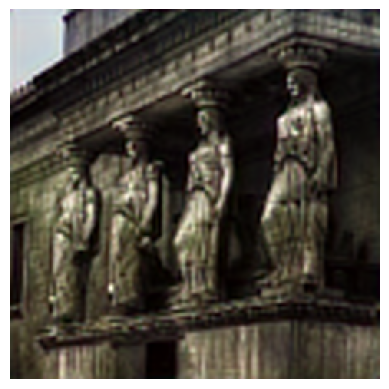

In [140]:
import torch
from torchvision import transforms
from PIL import Image


image_path = "/kaggle/input/landscape-image-colorization/landscape Images/gray/1941.jpg"


image = Image.open(image_path).convert("L")  


transform = transforms.Compose([
    transforms.Resize((224, 224)),        
    transforms.ToTensor()
])


image_tensor = transform(image)

image_tensor = image_tensor.unsqueeze(0) 

image_tensor.shape

res = model.predict(image_tensor).squeeze(0)
res = res.permute(1, 2, 0).cpu()

plt.imshow(res)
plt.axis('off')  
plt.show()



In [142]:
torch.save(model.state_dict(), "autoencoder_colorizer_v01.pt")

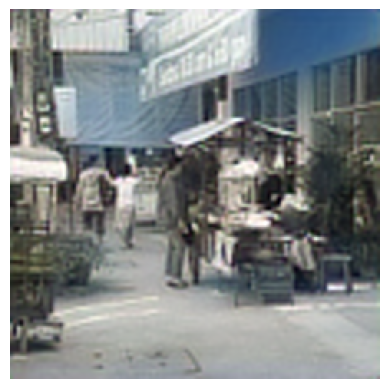

In [137]:
res = model.predict(image_tensor).squeeze(0)
res = res.permute(1, 2, 0).cpu()

plt.imshow(res)
plt.axis('off')  
plt.show()
